# Analysing British Airways customer reviews from Skytrax

This is a job simulation from British Airways (BA), where the goal is to analyse BA customer's reviews on the website [https://www.airlinequality.com/airline-reviews/british-airways] Each customer review consist of a written comment, an itemized summary of the trip (e.g. aircraft, route, date flown) and star-ratings of various services (e.g. Seat Comfort, Food & Beverages, Ground Service).

In what follows, we navigate to the website and scrape all the 1000 customers reviews. Each review have a written comment, but not necessarily a star-rating for all the items/services, therefore, some care most be taken to scrape the available information for each review. We achieve this by retrieving the informartion classified by "text_content", "review-stats" and "review-rating-header" in the html source code. Finally all the components of the reviews are stored in a python dictionary, which is later used to create its corresponding dataframe.

In [41]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

Reviews = []
Comments = []

for p in range(1, pages + 1):

    print(f"Scraping page {p}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{p}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content of each page
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    
    ## Scrape written reviews:
    writtenReviews = parsed_content.find_all("div", {"class":"text_content"})
    for i in range(len(writtenReviews)):
        ## Clean the format of each written review:
        entry = writtenReviews[i].get_text().split("|")
        if len(entry)==2:
            writtenReviews[i] = entry[1].lstrip()
    Comments += writtenReviews
        
    ## Scrape the statistics of each review:
    parsed_stats = parsed_content.find_all("div",{ "class":"review-stats"})
    parsed_stats
    
    headers_values = []
    stars_values = []
    chars_values = []
    for i in range(len(parsed_stats)):

        ## 1) headers for each review:
        headers_names = parsed_stats[i].find_all("td", {"class":"review-rating-header"})
        headers_i = []
        for j in range(len(headers_names)):
            headers_i.append(headers_names[j].get_text())
        headers_values.append(headers_i)

        ## 2) stars-ratings:
        stars_i = parsed_stats[i].find_all("td", {"class":"review-rating-stars"})
        for j in range(len(stars_i)):
            stars_i[j] = int(stars_i[j].find_all("span", {"class":"star fill"})[-1].get_text())
        stars_values.append(stars_i)

        ## 3) values of other characteristics of the flight:
        chars_i = parsed_stats[i].find_all("td", {"class":"review-value"})
        for j in range(len(chars_i)):
            chars_i[j] = chars_i[j].get_text()
        chars_values.append(chars_i)
    
    ## Organize the information of each review in a dictionary, using the header names as keys:
    reviews_all = []
    for i in range(len(parsed_stats)):
        review_i = {}
        reviews_i_values = chars_values[i][:-1] + stars_values[i] + [chars_values[i][-1]]
        for j in range(len(reviews_i_values)):
            review_i[ headers_values[i][j] ] = reviews_i_values[j]
        reviews_all.append(review_i)

    Reviews += reviews_all

    print(f"   ---> {len(reviews_all)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 100 total reviews
Scraping page 3
   ---> 100 total reviews
Scraping page 4
   ---> 100 total reviews
Scraping page 5
   ---> 100 total reviews
Scraping page 6
   ---> 100 total reviews
Scraping page 7
   ---> 100 total reviews
Scraping page 8
   ---> 100 total reviews
Scraping page 9
   ---> 100 total reviews
Scraping page 10
   ---> 100 total reviews


In [261]:
## Convert the collected info into a dataframe:
df = pd.DataFrame(Reviews)
df['Comment'] = Comments
df[:3]

,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Wifi & Connectivity,Value For Money,Recommended,Inflight Entertainment,Aircraft,Comment
0,Solo Leisure,Business Class,Antalya to Gatwick,October 2024,1.0,2.0,4.0,2.0,1.0,2,no,NaN,NaN,BA business class in Europe has a seat the sam...
1,Couple Leisure,Economy Class,London to Lisbon,September 2024,3.0,2.0,1.0,1.0,1.0,2,no,1.0,NaN,Our flight started in Seattle Wa heading to Li...
2,Solo Leisure,Economy Class,Edinburgh to Delhi via London,September 2024,1.0,1.0,1.0,1.0,NaN,1,no,NaN,NaN,British Airways Flight from Edinburgh got dela...


In [6]:
df.to_csv("data/BA_reviews.csv")

### Data overview:

Now we do some exploration on the data, to understand what we have and what questions to ask.

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Type Of Traveller       998 non-null    object 
 1   Seat Type               1000 non-null   object 
 2   Route                   996 non-null    object 
 3   Date Flown              1000 non-null   object 
 4   Seat Comfort            912 non-null    float64
 5   Cabin Staff Service     902 non-null    float64
 6   Food & Beverages        778 non-null    float64
 7   Ground Service          942 non-null    float64
 8   Wifi & Connectivity     324 non-null    float64
 9   Value For Money         1000 non-null   int64  
 10  Recommended             1000 non-null   object 
 11  Inflight Entertainment  518 non-null    float64
 12  Aircraft                528 non-null    object 
 13  Comment                 1000 non-null   object 
dtypes: float64(6), int64(1), object(7)
memory

The categories 'Type Of Traveller', 'Seat Type', 'Route', 'Date Flown', 'Recommended' and 'Aircraft' have worded answers. We will leave for further analysis the effect that the aircraft and the route has in the customer's experience: 'Aircraft' could be interesting to look at for potential correlations to seat-comfort, whereas 'Date flown' could provide, for example, information on domestic vs. international flights It could also be interesting to create an interface with Google Maps to extract the absolute origin-destination distant and see if it shows any correlation to customer's comfort. This however will be a rough approximation since we don't have information of lay-overs, which could have a large effect. 

#### Date Flown:

The date is given as a string "Month Year". Here we split the string, replace the name of the month with its number via a predefined dictionary, and plot them on histograms. The distribution on the months is more or less stables throught the year, except for February, April and May that showed less activity. As for the years, one clearly sees the effect of COVID19. We might come back to this later on in the analysis.

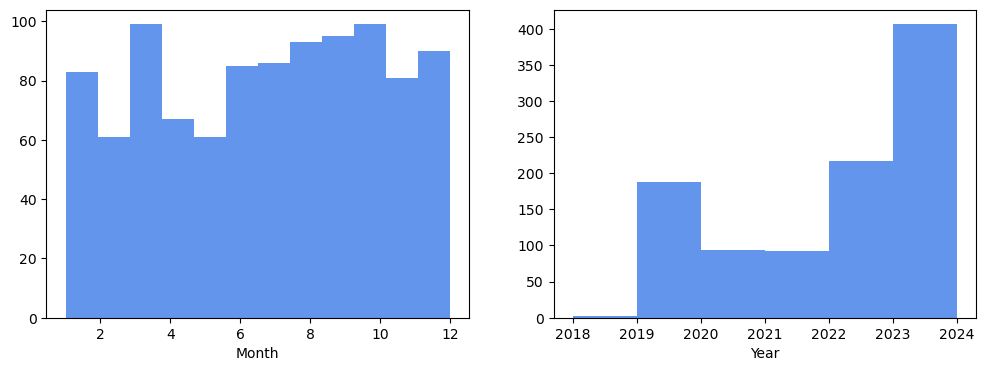

In [73]:
## Define dictionary to convert names of months into numbers:
MonthsHeaders = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthsDic = {}
for i in range(12):
    monthsDic[MonthsHeaders[i]] = i+1

## Collecting all the months and years separately:
months_tracker = []
years_tracker = []
for i in range(len(df['Date Flown'].dropna())):
    month, year = df['Date Flown'][i].split(' ')
    months_tracker.append(monthsDic[month])
    years_tracker.append(int(year))

## Plot histogram:
xlabels = ['Month', 'Year']
xdata = [months_tracker, years_tracker]
binN = [12, max(years_tracker)-min(years_tracker)]
ticksLabels = [MonthsHeaders, np.arange(min(years_tracker), max(years_tracker), 1)]

fig, axs = plt.subplots(1,2)
fig.set_size_inches(12,4)
for colm in range(2):
    axs[colm].hist( xdata[colm], align='mid', color='cornflowerblue', bins=binN[colm])
    axs[colm].set_xlabel(xlabels[colm])
    #axs[colm].Axis.set_label_text(ticksLabels[colm])
    
plt.show()

#### Type of traveller and seat:

Below are shown the pie distributions of the type of travellers (solo leisure, couple leisure, family leisure and business) as well as the types of seat (economy, premium economy, business and first class).
The reason for travelling seems to be uniformily distributed among the options. The seat type on the other hand shows that the economy class is the dominant one, with more than half of the trips, next is business, and less frequent are Premium economy and first class.

These two factors could have strong effect on the traveller's experience, so we will keep inspecting them as we move forward.

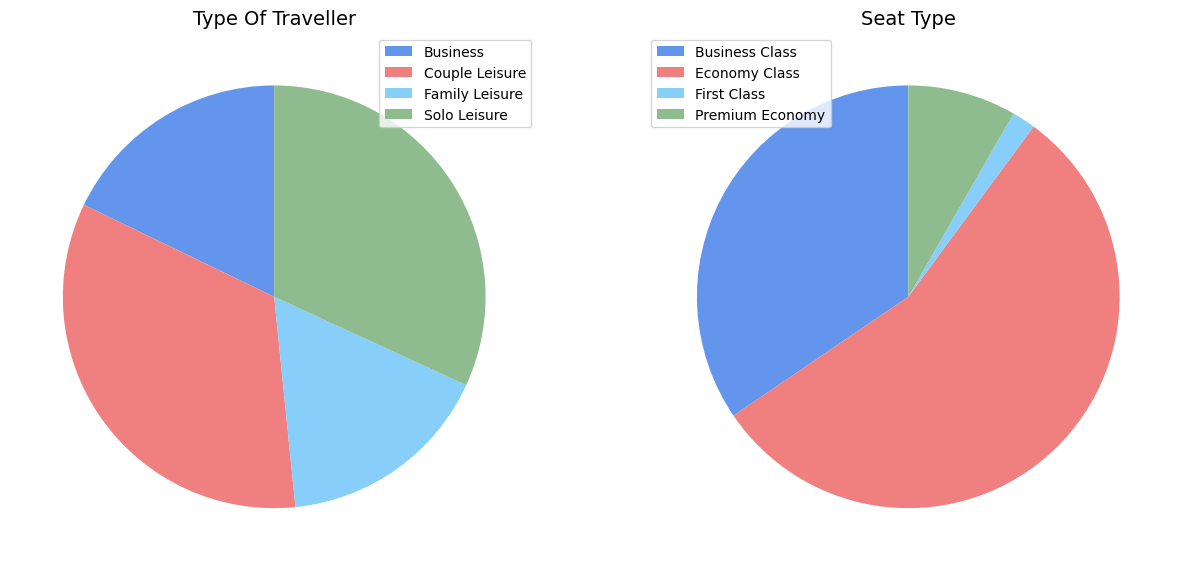

In [61]:
char_features = [ 'Type Of Traveller','Seat Type']

fig, axs = plt.subplots(1,2)
fig.set_size_inches(15,8)

for colm in range(2):
    df_dummies = pd.get_dummies(df[char_features[colm]]).astype(int)

    labels = df_dummies.columns
    colors = ['cornflowerblue', 'lightcoral', 'lightskyblue', 'darkseagreen']
    patches, texts = axs[colm].pie(df_dummies.sum(), colors=colors, startangle=90)
    axs[colm].legend(patches, labels, loc="best")
    axs[colm].set_title(char_features[colm], fontsize=14)

plt.show()

#### Star-ratings:

Now we look into the star rating given by the customer on 'Seat Comfort','Cabin Staff Service', 'Food & Beverages', 'Inflight Entertainment', 'Ground Service' and 'Wifi & Connectivity'. Below are the corresponding histograms with the total number of reviews for each category. The red line shown the average. For categories like 'seat comfort', 'ground services' and even 'cabin staff service' one can replace the missing data with their averages. However, for 'wifi and connectivity' and 'inflight entertainment' doing so could introduce a strong bias in the data since the amount of missing data is quite large. In what follows I have decided to keep the missing data as it is, to be interpreted as the number or customer who did not provide a rating.

The cabin staff service shows the best result. It is indeed the only category where the largest numbered rating is not one, but in fact five. The rest of the services could use some improvement, especially ground service!

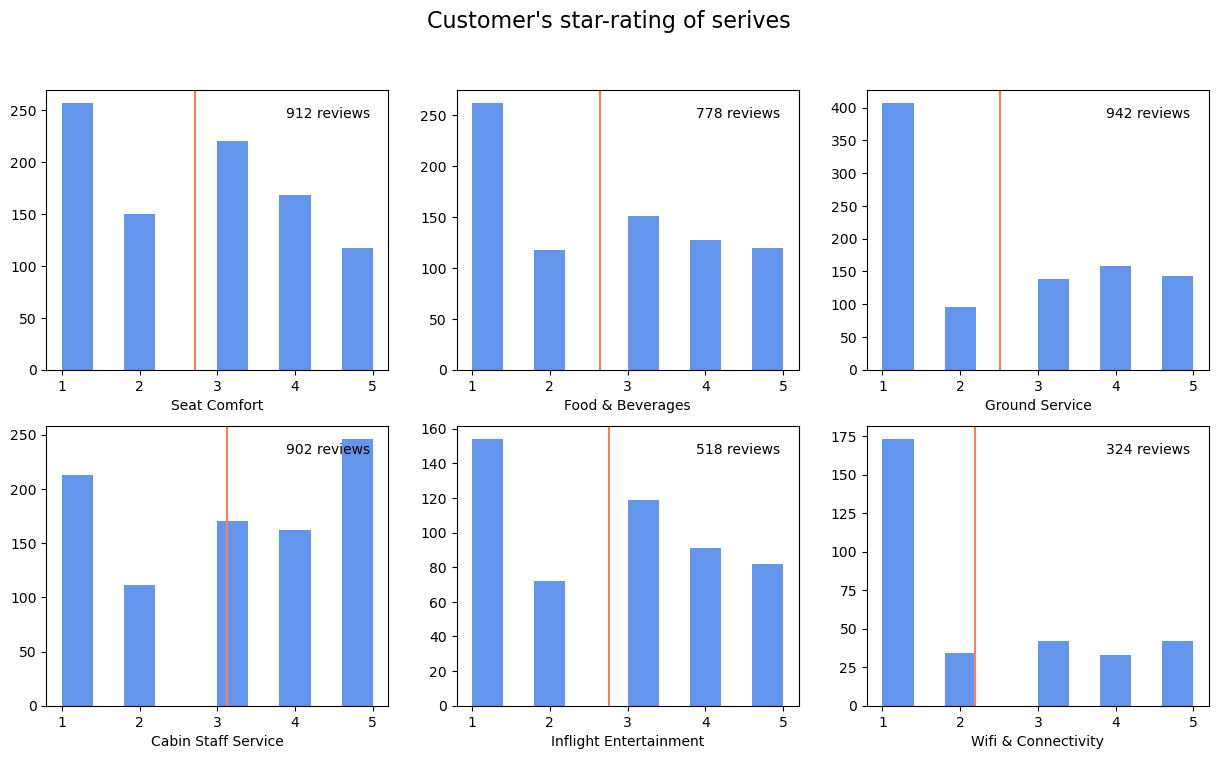

In [63]:
num_features = ['Seat Comfort','Cabin Staff Service', 'Food & Beverages', 'Inflight Entertainment', 'Ground Service', 'Wifi & Connectivity' ]

fig, axs = plt.subplots(2,3)
fig.set_size_inches(15,8)
fig.suptitle("Customer's star-rating of serives", fontsize=16)
i=0
for colm in range(3):
    for row in range(2):
        axs[row][colm].hist( df[num_features[i]].dropna(), align='mid', color='cornflowerblue')
        axs[row][colm].axvline(x=df[num_features[i]].mean(), color='coral', linestyle='-')
        axs[row][colm].set_xlabel(num_features[i])
        tx = str(int(len(df[num_features[i]].dropna())))+' reviews'
        axs[row][colm].text(0.7,0.9, tx, transform=axs[row][colm].transAxes )
        i += 1
plt.show()

#### Would customers recommend British Airways?

The result is not favorable. I think that people feel more incline to take the time of leaving a review when they were not satisfied with the service. If this is the case, British Airways might be at a better position than the plot bellow sugests. However, if these are most of the reviews that lead to customers not having a good experience, then these are precisely the reviews we should be looking at to improve the service.

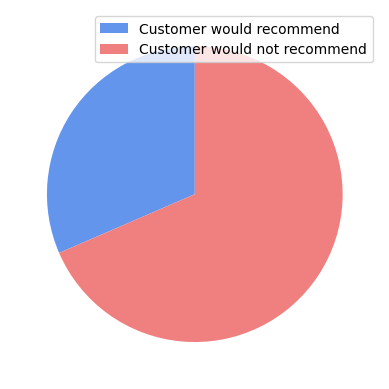

In [71]:
df_recommendation = pd.get_dummies(df['Recommended'], dtype=int)
no = df_recommendation['no'].sum()
yes = df_recommendation['yes'].sum()

fig, axs = plt.subplots(1)
labels = ['Customer would recommend','Customer would not recommend']
colors = ['cornflowerblue', 'lightcoral']
patches, texts = axs.pie([yes,no], colors=colors, startangle=90)
axs.legend(patches, labels, loc="upper right")

#### Sentiment Analysis:

Now we turn into the written comments left by the customers thought a "sentiment analysis". We use TextBlob to report a quantitative measure of the review's "polarity" and "subjectivity". Both parameters are a floating number between 0 and 1. Maximum polarity implies a positive experience and minimum subjectivity could be behind constructive criticism. 

In [350]:
#!pip install textblob
import textblob

## Obtaining the polarity and subjectivity scores:
## The polarity score is a float within the range [-1.0, 1.0]. 
## The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.
pol_list, pol_norm_list  = [], []
sub_list = []
for i in range(len(df)):
    review = textblob.TextBlob(df['Comment'][i])
    pol_list.append(review.sentiment.polarity)
    pol_norm_list.append( (review.sentiment.polarity +1)/2 )
    sub_list.append(review.sentiment.subjectivity)

#df['polarity'] = pol_list
df['normalized_polarity'] = pol_norm_list
df['normalized_subjectivity'] = sub_list

The results of the sentiment analysis are plotten below. They confirm what one would expect: the cases where customers replied that they would indeed recommend the airline are located in the second and third (horizontal) section of the polarity-subjectivity plane. The top right corner seem to correspond to the cases where the customers had a very positive experience, the oposite applies to the top left corner. The star-rating histograms also show a reasonable behaviour.

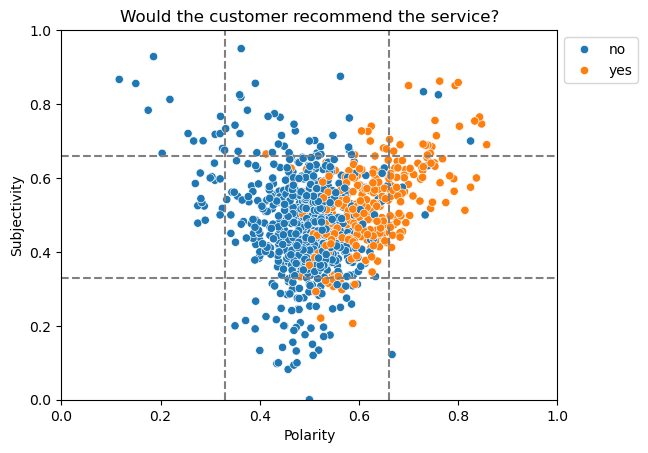

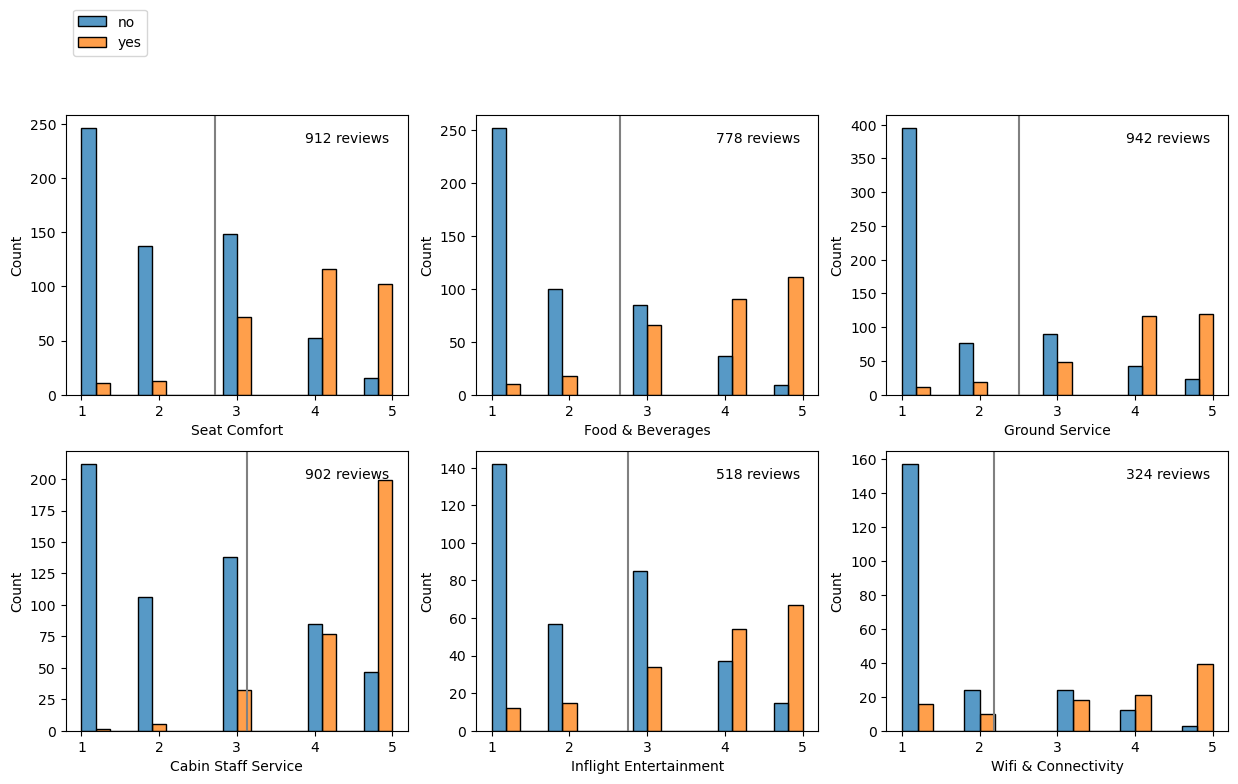

In [354]:
## Scatter plot in the polarity-subjectivity plain:
g = sns.scatterplot(data=df, x='normalized_polarity', y='normalized_subjectivity', hue="Recommended")
sns.move_legend(g, "upper left", title='', frameon=True, bbox_to_anchor=(1, 1))
g.axvline(x=0.33, color='gray', linestyle='--')
g.axvline(x=0.66, color='gray', linestyle='--')
g.axhline(y=0.33, color='gray', linestyle='--')
g.axhline(y=0.66, color='gray', linestyle='--')
g.set_xlim(0, 1)
g.set_ylim(0,1)
g.set_xlabel('Polarity')
g.set_ylabel('Subjectivity')
g.set_title("Would the customer recommend the service?")
plt.show()



## Proportion of 'yes' and 'no' in each of the star-rating services:
num_features = ['Seat Comfort','Cabin Staff Service', 'Food & Beverages', 'Inflight Entertainment', 'Ground Service', 'Wifi & Connectivity' ]
num_features_sql = ['Seat_Comfort','Cabin_Staff_Service', 'Food_and_Beverages', 'Inflight_Entertainment', 'Ground_Service', 'Wifi_and_Connectivity' ]
columns = 3
rows = 2
fig, axs = plt.subplots(rows,columns)
fig.set_size_inches(15,8)
#fig.suptitle("Customer's star-rating ...would they recommend British Airways? ", fontsize=16)
i=0
for colm in range(columns):
    for row in range(rows):
        if i==0:
            pl = sns.histplot(ax=axs[row][colm], data=df, x=df[num_features[i]].dropna(), multiple='dodge', hue='Recommended')
            sns.move_legend(pl, "upper left", title='', frameon=True, bbox_to_anchor=(0, 1.4))
        else:
            pl = sns.histplot(ax=axs[row][colm], data=df, x=df[num_features[i]].dropna(), multiple='dodge', hue='Recommended', legend=False)
        axs[row][colm].axvline(x=df[num_features[i]].mean(), color='gray', linestyle='-')
        tx = str(int(len(df[num_features[i]].dropna())))+' reviews'
        axs[row][colm].text(0.7,0.9, tx, transform=axs[row][colm].transAxes )
        i += 1
plt.show()

In [17]:
## Other features include identifying-sentences and counting phrases:

#for i in range(1):#len(df)):
#    review = textblob.TextBlob(df['reviews'][i])
#    sentences = review.sentences
#    print(sentences)
#    print(review.noun_phrases.count('insert_phrase'))

#### WordClouds:   

#### SQL queries:

In [79]:
import csv, sqlite3

## Credentials of the DB2 database:
dsn_hostname = "98538591-7217-4024-b027-8baa776ffad1.c3n41cmd0nqnrk39u98g.databases.appdomain.cloud" # e.g.: "54a2f15b-5c0f-46df-8954-7e38e612c2bd.c1ogj3sd0tgtu0lqde00.databases.appdomain.cloud"
dsn_uid = "mzf99447"        # e.g. "abc12345"
dsn_pwd = "7OvJosruh343brjZ"      # e.g. "7dBZ3wWt9XN6$o0J"
dsn_database = "bludb"            # e.g. "BLUDB"
dsn_port = "30875"                # e.g. "32733" 
dsn_protocol = "TCPIP"            # i.e. "TCPIP"
dsn_security = "SSL"              #i.e. "SSL"
# %sql ibm_db_sa://my-username:my-password@hostname:port/BLUDB?security=SSL

## Connect to the DB2 database:
%load_ext sql
%sql ibm_db_sa://mzf99447:7OvJosruh343brjZ@98538591-7217-4024-b027-8baa776ffad1.c3n41cmd0nqnrk39u98g.databases.appdomain.cloud:30875/BLUDB?security=SSL


The sql extension is already loaded. To reload it, use:
  %reload_ext sql


Now we create a connection to a database called AIRLINE as well as the cursor object. Then we can create a table also called AIRLINE:

In [81]:
## Connect to SQLite:
con = sqlite3.connect("AIRLINE.db")
cursor_obj = con.cursor()

In [83]:
## Create the table:
drop_query = """ drop table AIRLINE;"""
cursor_obj.execute(drop_query)

createQuery = """ CREATE TABLE AIRLINE(
    Type_Of_Traveller VARCHAR(20), 
    Seat_Type VARCHAR(20),
    Route VARCHAR(20),
    Date_Flown VARCHAR(20),
    Seat_Comfort VARCHAR(20),
    Cabin_Staff_Service VARCHAR(20) ,
    Food_and_Beverages VARCHAR(20),
    Ground_Service VARCHAR(20),
    Value_For_Money VARCHAR(20),
    Aircraft VARCHAR(20),
    Inflight_Entertainment VARCHAR(20),
    Wifi_and_Connectivity VARCHAR(20),
    Recommended VARCHAR(20) ,
    normalized_polarity FLOAT,
    normalized_subjectivity FLOAT );"""
cursor_obj.execute(createQuery)

con.commit()

In [85]:
%sql sqlite:///AIRLINE.db
%sql SELECT * FROM AIRLINE LIMIT 5;

   ibm_db_sa://mzf99447:***@98538591-7217-4024-b027-8baa776ffad1.c3n41cmd0nqnrk39u98g.databases.appdomain.cloud:30875/BLUDB?security=SSL
 * sqlite:///AIRLINE.db
Done.


Type_Of_Traveller,Seat_Type,Route,Date_Flown,Seat_Comfort,Cabin_Staff_Service,Food_and_Beverages,Ground_Service,Value_For_Money,Aircraft,Inflight_Entertainment,Wifi_and_Connectivity,Recommended,normalized_polarity,normalized_subjectivity


To clean the format of the data, we'll:

    .) Replace double-quotation marks within the comments with single-quotation marks, so the database populating with SQL goes smoother.

    .) Replace the missing values with the integer -1. We won't replace them with averages to avoid introducing strong biases into the data, especially in cases where a smaller fraction of the customers gave a star rating.

In [87]:
for feature in num_features:
    df[feature] = df[feature].replace({np.nan: -1})
    df[feature] = df[feature].astype(int)
df['Comment'] = df['Comment'].replace({'"': "\'"}, regex=True)
df['normalized_polarity'] = round(df['normalized_polarity'],3)
df['normalized_subjectivity'] = round(df['normalized_subjectivity'],3)

We proceed now to fill the table from the panda dataframe:

In [93]:
## Fill the table:
for i in range(len(df)):
    #review = df['reviews'][i]
    fillQuery = "INSERT INTO AIRLINE VALUES ( "
    fillQuery += '"' + str(df['Type Of Traveller'][i]) + '", '
    fillQuery += '"' + str(df['Seat Type'][i])+ '", '
    fillQuery += '"' + str(df['Route'][i])+ '", '
    fillQuery += '"' + str(df['Date Flown'][i])+ '", '
    fillQuery += str(df['Seat Comfort'][i])+ ', '
    fillQuery += str(df['Cabin Staff Service'][i])+ ', '
    fillQuery += str(df['Food & Beverages'][i])+ ' , '
    fillQuery += str(df['Ground Service'][i])+ ' , '
    fillQuery += str(df['Value For Money'][i])+ ' , '
    fillQuery += '"' + str(df['Aircraft'][i])+ '", '
    fillQuery += str(df['Inflight Entertainment'][i])+ ' , '
    fillQuery += str(df['Wifi & Connectivity'][i])+ ' , '
    #fillQuery += '"' + str(df['Comment'][i])+ '", '
    fillQuery += '"' + str(df['Recommended'][i])+ '" , '
    fillQuery += str(df['normalized_polarity'][i])+  ' , '
    fillQuery += str(df['normalized_subjectivity'][i])+ ' );'

    #print(i, fillQuery)
    cursor_obj.execute(fillQuery)

con.commit()
cursor_obj.close()

In [95]:
%sql sqlite:///AIRLINE.db
%sql SELECT * FROM AIRLINE LIMIT 5;

   ibm_db_sa://mzf99447:***@98538591-7217-4024-b027-8baa776ffad1.c3n41cmd0nqnrk39u98g.databases.appdomain.cloud:30875/BLUDB?security=SSL
 * sqlite:///AIRLINE.db
Done.


Type_Of_Traveller,Seat_Type,Route,Date_Flown,Seat_Comfort,Cabin_Staff_Service,Food_and_Beverages,Ground_Service,Value_For_Money,Aircraft,Inflight_Entertainment,Wifi_and_Connectivity,Recommended,normalized_polarity,normalized_subjectivity
Solo Leisure,Business Class,Antalya to Gatwick,October 2024,1,2,4,2,2,nan,-1,1,no,0.503,0.477
Couple Leisure,Economy Class,London to Lisbon,September 2024,3,2,1,1,2,nan,1,1,no,0.514,0.436
Solo Leisure,Economy Class,Edinburgh to Delhi via London,September 2024,1,1,1,1,1,nan,-1,-1,no,0.457,0.082
Solo Leisure,Premium Economy,London to Vancouver,September 2024,4,5,2,3,2,A350,1,-1,yes,0.588,0.529
Business,Economy Class,Gatwick to Amsterdam,September 2024,3,4,1,3,1,A320,1,1,no,0.504,0.3


In [30]:
## If database is locked:
#!fuser REVIEWS.db
#!kill -9 above_output_number

In [99]:
seat_types = ['Economy Class', 'Premium Economy', 'Business Class', 'First Class']
seat_will_recomm = []
seat_will_recomm_perc = []

cursor_obj = con.cursor()
for i in range(len(seat_types)):
    string_yes = str('SELECT * FROM AIRLINE WHERE Recommended="yes" AND seat_type = "' + seat_types[i] + '";')
    string_yes_value = pd.read_sql(string_yes, con)
    
    string_all = str('SELECT * FROM AIRLINE WHERE seat_type = "' + seat_types[i] + '";')
    string_all_value = pd.read_sql(string_all, con)

    abs = len(string_yes_value)
    per = round(len(string_yes_value)/len(string_all_value)*100,2)
    seat_will_recomm_perc.append(per)
    seat_will_recomm.append(abs)

    print(seat_types[i], per, abs, len(string_all_value))

    if i ==0:
        economy_df = string_all_value
    elif i == 1:    
        premium_economy_df =string_all_value
    elif i==2:
        business_df =string_all_value
    elif i==3:
        first_class_df =string_all_value


cursor_obj.close()

Economy Class 25.09 139 554
Premium Economy 28.92 24 83
Business Class 41.74 144 345
First Class 44.44 8 18


In [101]:
traveller_types = ['Solo Leisure', 'Couple Leisure', 'Family Leisure', 'Business']
traveller_will_recomm = []
traveller_will_recomm_perc = []

cursor_obj = con.cursor()

for i in range(len(seat_types)):
    string_yes = str('SELECT * FROM AIRLINE WHERE Recommended="yes" AND Type_Of_Traveller = "' + traveller_types[i] + '";')
    string_yes_value = pd.read_sql(string_yes, con)
    
    string_all = str('SELECT * FROM AIRLINE WHERE type_of_traveller = "' + traveller_types[i] + '";')
    string_all_value = pd.read_sql(string_all, con)

    abs =len(string_yes_value)
    per = round(len(string_yes_value)/len(string_all_value)*100,2)
    traveller_will_recomm_perc.append(per)
    traveller_will_recomm.append(abs)
    
    print(traveller_types[i], per, abs, len(string_all_value))

    if i ==0:
        soloT_df = string_all_value
    elif i == 1:    
        coupleT_df =string_all_value
    elif i==2:
        familyT_df =string_all_value
    elif i==3:
        businessT_df =string_all_value
    
cursor_obj.close()

Solo Leisure 38.68 123 318
Couple Leisure 32.94 111 337
Family Leisure 30.3 50 165
Business 17.42 31 178


## How is the customer's experience affected by their seat type?

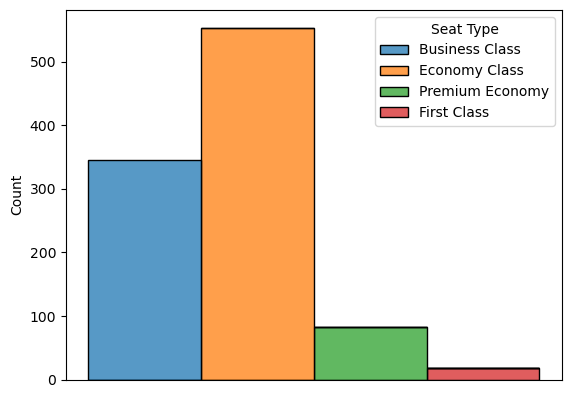

In [363]:
## Histogram of the number of customers per seat type:
seat_hist = sns.histplot(data=df, x=df['Seat Type'], stat="count", multiple="stack", hue="Seat Type")
seat_hist.set_xlabel('')
seat_hist.set_xticklabels('')
seat_hist.set_xticks([])
plt.show()

The plot above show the number of customers classified by their seat type. As expected, the dominant class is the economy class, followed by the business class. Less common are the premium economy and first class. 

The plots below show the polarity-subjectivity plane and an equivalen visualization of the polarity per type of seat. From either plot one can see that the mayor (negative) outliers corresponds to customers in the business and in the economy class, which incidentally are the most common types. Otherwise, the feedback is neutral to good. 

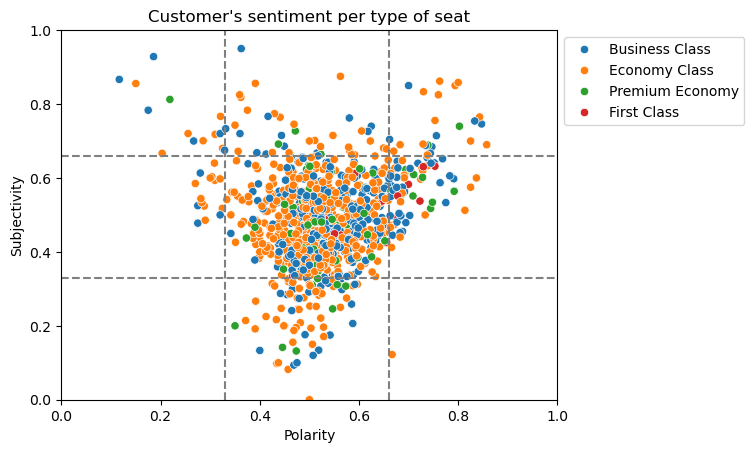

/tmp/ipykernel_254110/3259833381.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.catplot(x=df['Seat Type'], y=df['normalized_polarity'], kind='box', palette='tab10')


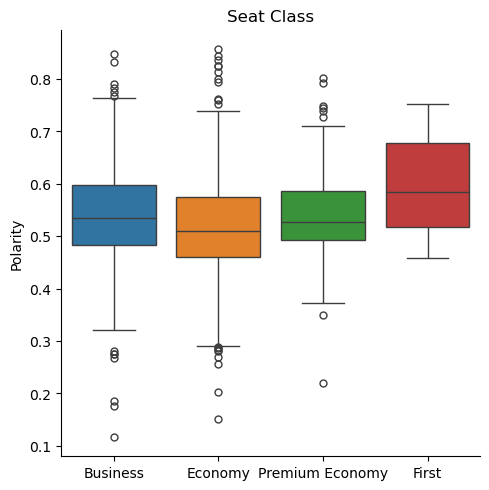

In [366]:
## Polarity-subjectivity plane per type of seat:
g = sns.scatterplot(data=df, x='normalized_polarity', y='normalized_subjectivity', hue="Seat Type")
sns.move_legend(g, "upper left", title='', frameon=True, bbox_to_anchor=(1, 1))
g.axvline(x=0.33, color='gray', linestyle='--')
g.axvline(x=0.66, color='gray', linestyle='--')
g.axhline(y=0.33, color='gray', linestyle='--')
g.axhline(y=0.66, color='gray', linestyle='--')
g.set_xlim(0, 1)
g.set_ylim(0,1)
g.set_xlabel('Polarity')
g.set_ylabel('Subjectivity')
g.set_title("Customer's sentiment per type of seat")
plt.show()


## Polarity as a function of the type of seat:
plot = sns.catplot(x=df['Seat Type'], y=df['normalized_polarity'], kind='box', palette='tab10')
plot.set_xticklabels(['Business', 'Economy', 'Premium Economy', 'First']) 
plt.title('Seat Class')
plt.xlabel('')
plt.ylabel('Polarity')
plt.show()

Finally, the plot below breaks down the star-rating reviews per type of seat. 

Most of the complains on the seat comfort came from customer in the economy class. 

In [ ]:
fig, axs = plt.subplots(2,3)
fig.set_size_inches(15,8)
fig.suptitle("Customer's star-rating of serives", fontsize=16)
i=0
for colm in range(3):
    for row in range(2):
        if i==0:
            pl = sns.histplot(ax=axs[row][colm], x=economy_df[num_features[i]])
            sns.move_legend(pl, "upper left", title='', frameon=True, bbox_to_anchor=(0, 1.4))
        else:
            pl = sns.histplot(ax=axs[row][colm], data=df, x=df[num_features[i]], multiple="dodge", hue='Seat Type', legend=False)
        axs[row][colm].axvline(x=df[num_features[i]].mean(), color='gray', linestyle='-')
        tx = str(int(len(df[num_features[i]].dropna())))+' reviews'
        axs[row][colm].text(0.7,0.9, tx, transform=axs[row][colm].transAxes )
        i += 1
plt.show()

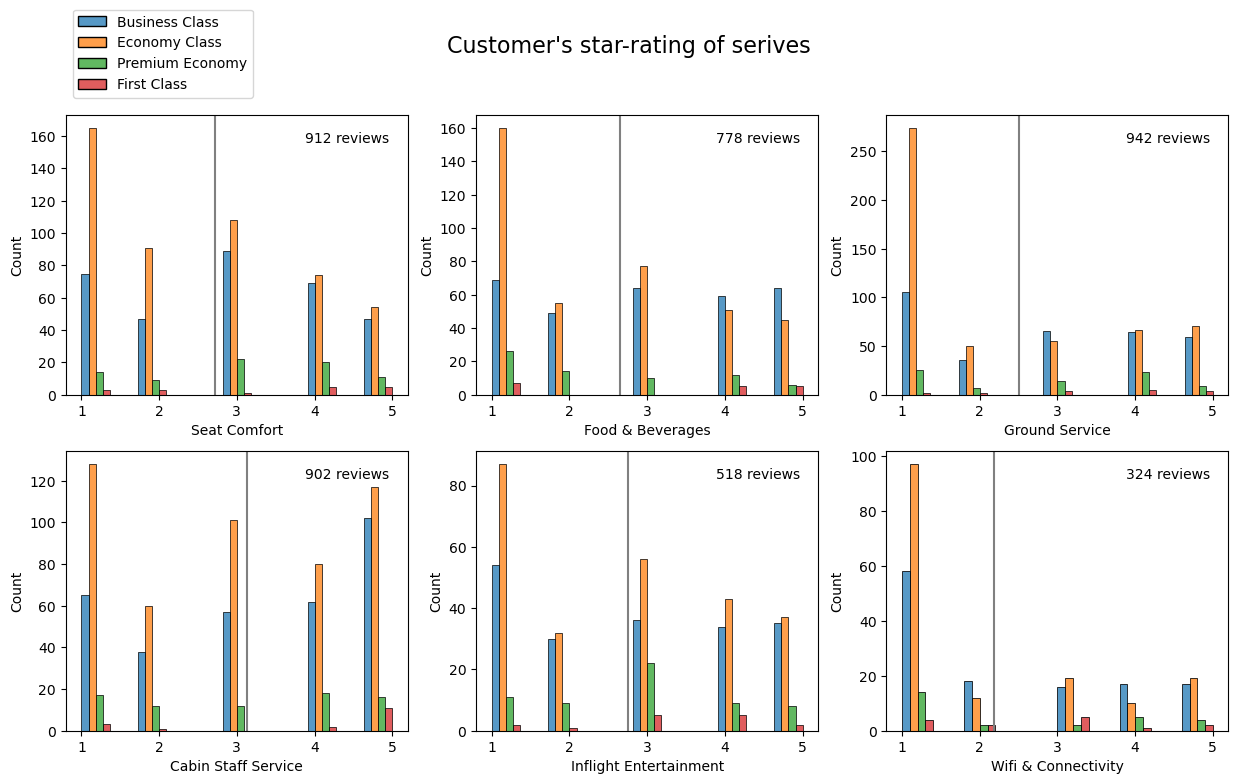

In [375]:
fig, axs = plt.subplots(2,3)
fig.set_size_inches(15,8)
fig.suptitle("Customer's star-rating of serives", fontsize=16)
i=0
for colm in range(3):
    for row in range(2):
        if i==0:
            pl = sns.histplot(ax=axs[row][colm], data=df, x=df[num_features[i]], multiple='dodge', hue='Seat Type')
            sns.move_legend(pl, "upper left", title='', frameon=True, bbox_to_anchor=(0, 1.4))
        else:
            pl = sns.histplot(ax=axs[row][colm], data=df, x=df[num_features[i]], multiple="dodge", hue='Seat Type', legend=False)
        axs[row][colm].axvline(x=df[num_features[i]].mean(), color='gray', linestyle='-')
        tx = str(int(len(df[num_features[i]].dropna())))+' reviews'
        axs[row][colm].text(0.7,0.9, tx, transform=axs[row][colm].transAxes )
        i += 1
plt.show()

## How is the customer's experience affected by the purpose of their trip?

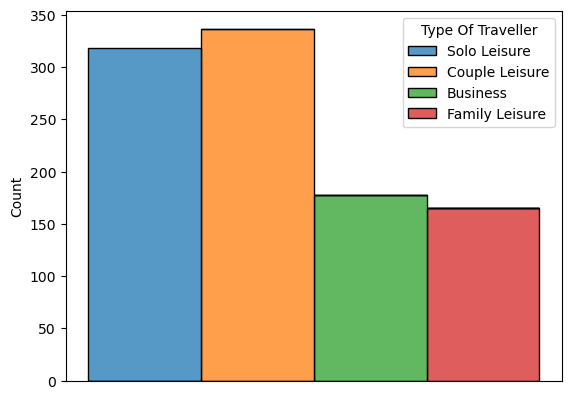

In [431]:
seat_hist = sns.histplot(data=df, x=df['Type Of Traveller'], stat="count", multiple="stack", hue="Type Of Traveller")
seat_hist.set_xlabel('')
seat_hist.set_xticklabels('')
seat_hist.set_xticks([])
plt.show()

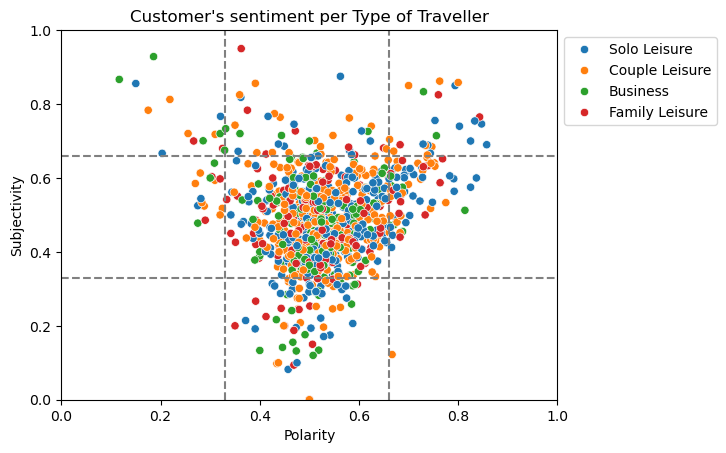

/tmp/ipykernel_254110/2796686413.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.catplot(x=df['Type Of Traveller'], y=df['normalized_polarity'], kind='box', palette='tab10')


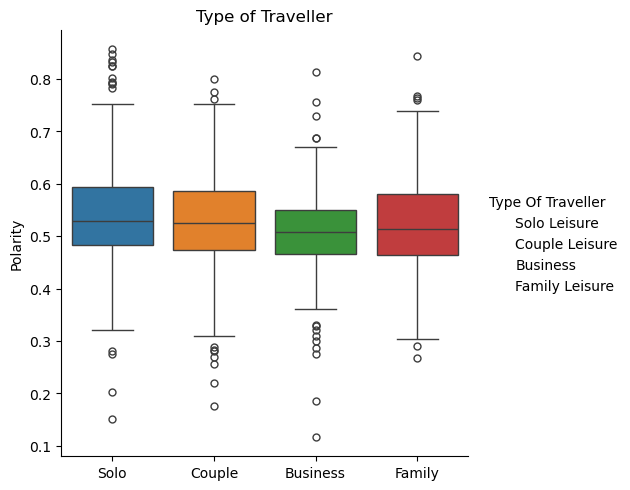

In [433]:
## Polarity-subjectivity plane per type of seat:
g = sns.scatterplot(data=df, x='normalized_polarity', y='normalized_subjectivity', hue="Type Of Traveller")
sns.move_legend(g, "upper left", title='', frameon=True, bbox_to_anchor=(1, 1))
g.axvline(x=0.33, color='gray', linestyle='--')
g.axvline(x=0.66, color='gray', linestyle='--')
g.axhline(y=0.33, color='gray', linestyle='--')
g.axhline(y=0.66, color='gray', linestyle='--')
g.set_xlim(0, 1)
g.set_ylim(0,1)
g.set_xlabel('Polarity')
g.set_ylabel('Subjectivity')
g.set_title("Customer's sentiment per Type of Traveller")
plt.show()

## Polarity as a function of the type of seat:
plot = sns.catplot(x=df['Type Of Traveller'], y=df['normalized_polarity'], kind='box', palette='tab10')
plot.set_xticklabels(['Solo', 'Couple', 'Business', 'Family']) 
plt.title('Type of Traveller')
plt.xlabel('')
plt.ylabel('Polarity')
plt.show()


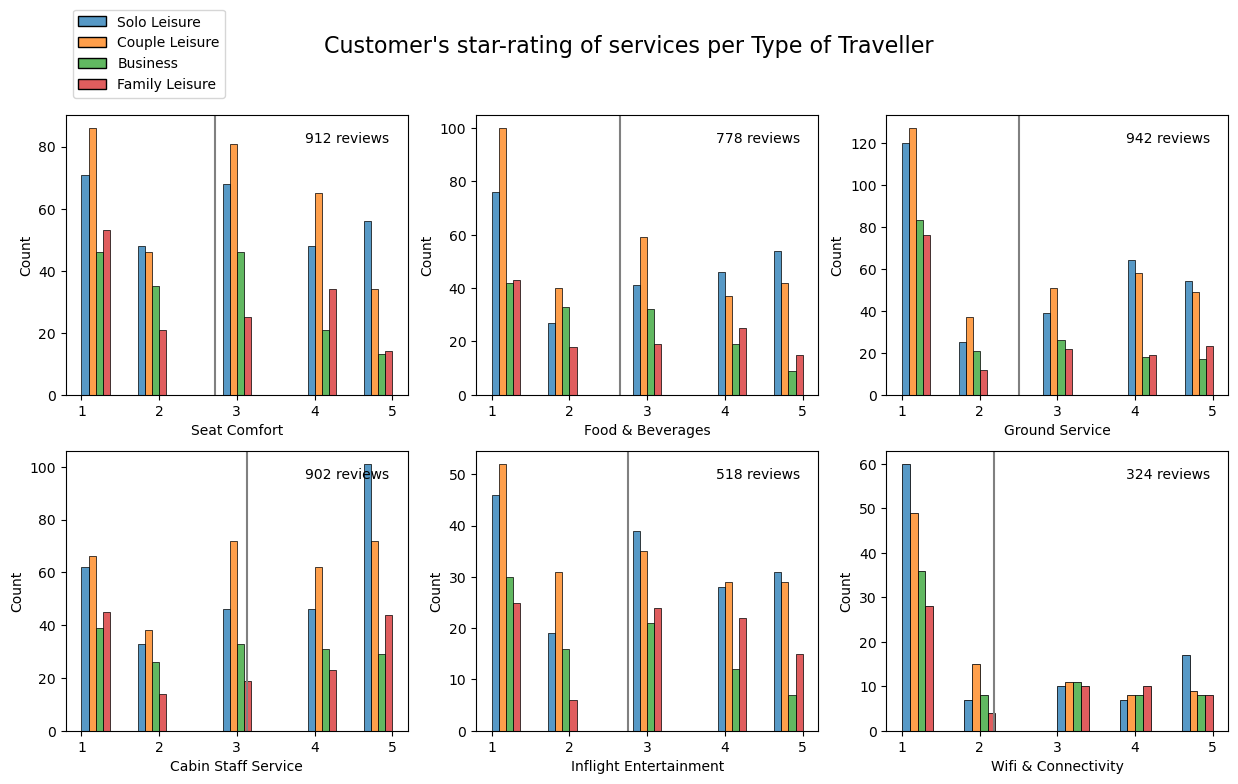

In [359]:
num_features = ['Seat Comfort','Cabin Staff Service', 'Food & Beverages', 'Inflight Entertainment', 'Ground Service', 'Wifi & Connectivity' ]

fig, axs = plt.subplots(2,3)
fig.set_size_inches(15,8)
fig.suptitle("Customer's star-rating of services per Type of Traveller", fontsize=16)
i=0
for colm in range(3):
    for row in range(2):
        if i==0:
            pl = sns.histplot(ax=axs[row][colm], data=df, x=df[num_features[i]].dropna(), multiple='dodge', hue='Type Of Traveller')
            sns.move_legend(pl, "upper left", title='', frameon=True, bbox_to_anchor=(0, 1.4))
        else:
            pl = sns.histplot(ax=axs[row][colm], data=df, x=df[num_features[i]].dropna(), multiple='dodge', hue='Type Of Traveller', legend=False)
        axs[row][colm].axvline(x=df[num_features[i]].mean(), color='gray', linestyle='-')
        tx = str(int(len(df[num_features[i]].dropna())))+' reviews'
        axs[row][colm].text(0.7,0.9, tx, transform=axs[row][colm].transAxes )
        i += 1
plt.show()